# User reviews classifier to predict of a product review will be useful for other users. (Data set Amazon)


**Use Case**: As user prepares and submits a review, how can companies proactively identify reviews not to be posted towards an item that as not a helpful for other users?

**Target Variable** Helpful response from other reviewers (this is a target variable that is constructed by a rating on actual reviews done by other users using the scale from vote or helpful)

**Data Source** https://nijianmo.github.io/amazon/index.html



In [4]:
import os
import json
import gzip
import wget
import pandas as pd
from urllib.request import urlopen
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# tested links
- http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz - works
- http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz - works


In [5]:
##download data from url
### randomly selected file to model
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz'
filename = wget.download(url)


In [6]:
#load metadata
data = []
with gzip.open('Grocery_and_Gourmet_Food_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

1143860
{'overall': 5.0, 'verified': True, 'reviewTime': '11 19, 2014', 'reviewerID': 'A1QVBUH9E1V6I8', 'asin': '4639725183', 'reviewerName': 'Jamshed Mathur', 'reviewText': 'No adverse comment.', 'summary': 'Five Stars', 'unixReviewTime': 1416355200}


In [7]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))


1143860


In [8]:
#look at dataframe
df.info()
display(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1143860 non-null  float64
 1   verified        1143860 non-null  bool   
 2   reviewTime      1143860 non-null  object 
 3   reviewerID      1143860 non-null  object 
 4   asin            1143860 non-null  object 
 5   reviewerName    1143722 non-null  object 
 6   reviewText      1143470 non-null  object 
 7   summary         1143641 non-null  object 
 8   unixReviewTime  1143860 non-null  int64  
 9   vote            158202 non-null   object 
 10  style           592086 non-null   object 
 11  image           9510 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 97.1+ MB


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1143855,5.0,True,"09 8, 2017",A223YRQH2Z5T1D,B01HJF6FRA,flint5292,"As a new vegan, it is sometimes difficult to r...","As a new vegan, it is sometimes difficult to ...",1504828800,4,NaN,NaN
1143856,5.0,True,"08 4, 2017",A38GDA4TB9EILT,B01HJF6FRA,Moriah Bolyard,The best thing ever is ordering a product you ...,The best thing ever is ordering a product you ...,1501804800,3,NaN,NaN
1143857,5.0,True,"07 4, 2017",A2025PN7HDC5BO,B01HJF6FRA,M.C,I used to love ranch before I became vegan. It...,Just what the vegan ordered!,1499126400,5,NaN,NaN
1143858,5.0,True,"06 7, 2017",A1NY7XWC7EPQOA,B01HJF6FRA,Greensboro,I cannot have dairy nor gluten. This is as cl...,This is as close to Ranch as I will ever be ab...,1496793600,2,NaN,NaN


### Data catalogue

- __overall:__- Rating of the Product
- __reviewTime:__- Time of the review (raw)
- __reviewerID:__- ID of the reviewer, e.g. A2SUAM1J3GNN3B
- __asin:__- ID of the product, e.g. 0000013714
- __style:__- A disctionary of the product metadata, e.g., "Format" is "Hardcover"
- __reviewerName:__- Name of the reviewer
- __reviewerText:__- Text of the review
- __summary:__- Summary of the review
- __vote:__- Helpful votes of the review
- __unixReviewTime:__- Time of the review (unix time)
- __reviewText:__- Text of the review
- __image:__- Images that users post after they have received the product

#### Remove Columns

In [9]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

In [10]:
#clean data
#drop columns that don't impact
df = df.drop(['style','summary','image'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1143860 non-null  float64
 1   verified        1143860 non-null  bool   
 2   reviewTime      1143860 non-null  object 
 3   reviewerID      1143860 non-null  object 
 4   asin            1143860 non-null  object 
 5   reviewerName    1143722 non-null  object 
 6   reviewText      1143470 non-null  object 
 7   unixReviewTime  1143860 non-null  int64  
 8   vote            158202 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 70.9+ MB


In [11]:
#convert column to string
df["reviewText"]=df["reviewText"].astype(str)

In [12]:
#convert vote column to float


df["vote"]= df["vote"].fillna(0)
df['vote']=df['vote'].str.replace(',','')

df["vote"] = df["vote"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143860 entries, 0 to 1143859
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1143860 non-null  float64
 1   verified        1143860 non-null  bool   
 2   reviewTime      1143860 non-null  object 
 3   reviewerID      1143860 non-null  object 
 4   asin            1143860 non-null  object 
 5   reviewerName    1143722 non-null  object 
 6   reviewText      1143860 non-null  object 
 7   unixReviewTime  1143860 non-null  int64  
 8   vote            158202 non-null   float64
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 70.9+ MB


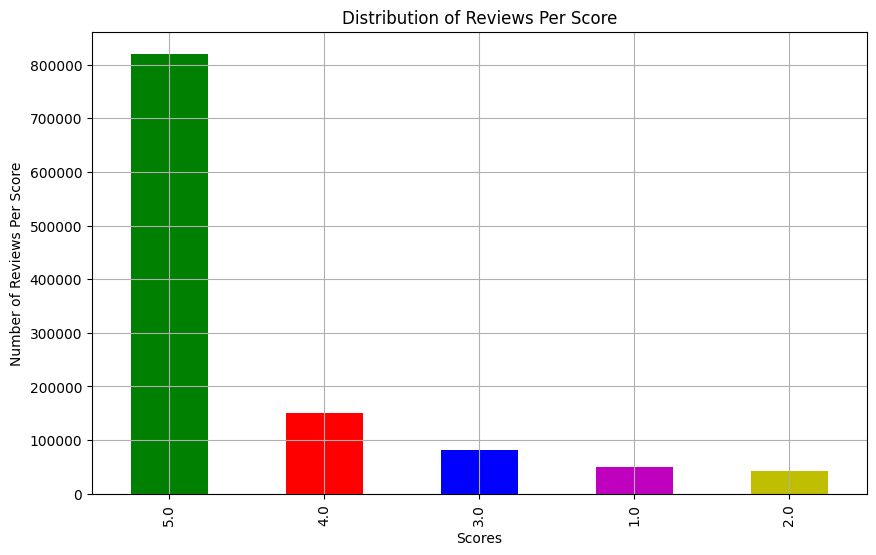

In [13]:
#create graph to check review distribution
category_dist = df['overall'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r', 'b', 'm', 'y']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Scores")
plt.ylabel("Number of Reviews Per Score")
plt.title("Distribution of Reviews Per Score")
plt.show()

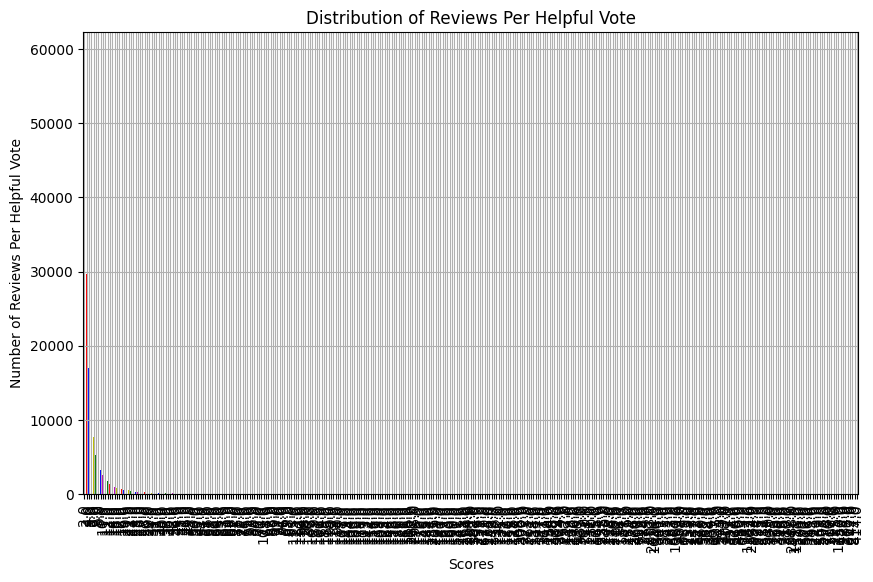

In [14]:
#create graphs to check helpfullness distribution
category_dist = df['vote'].value_counts()

plt.figure(figsize=(10,6))
my_colors = ['g', 'r', 'b', 'm', 'y']
category_dist.plot(kind='bar', color=my_colors)
plt.grid()
plt.xlabel("Scores")
plt.ylabel("Number of Reviews Per Helpful Vote")
plt.title("Distribution of Reviews Per Helpful Vote")
plt.show()

average length of review: 208.585


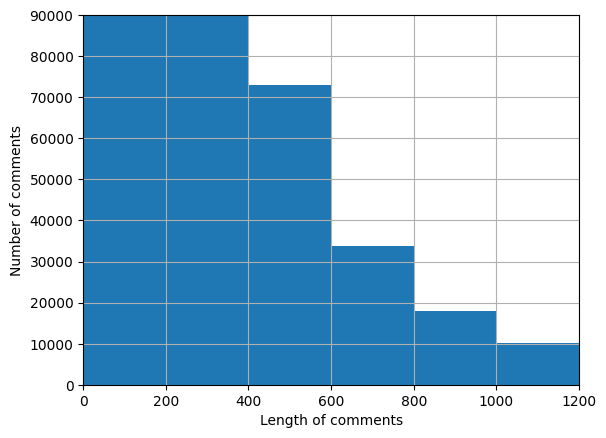

In [15]:
#look at comment length
x = [len(df['reviewText'][i]) for i in range(df['reviewText'].shape[0])]

print('average length of review: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

### Naive Bayes

Group 'overall' into 2 categories for simple Naive Bayes and the run a multinomial Naive Bayes.

In [16]:
#Import Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

In [17]:
#Naive Bayes
cv = CountVectorizer()
tfidf = TfidfVectorizer()

dfNB = df[['reviewText', 'overall']]

dfNB.dropna

<bound method DataFrame.dropna of                                                 reviewText  overall
0                                      No adverse comment.      5.0
1                                Gift for college student.      5.0
2        If you like strong tea, this is for you. It mi...      5.0
3        Love the tea. The flavor is way better than th...      5.0
4        I have searched everywhere until I browsed Ama...      5.0
...                                                    ...      ...
1143855  As a new vegan, it is sometimes difficult to r...      5.0
1143856  The best thing ever is ordering a product you ...      5.0
1143857  I used to love ranch before I became vegan. It...      5.0
1143858  I cannot have dairy nor gluten.  This is as cl...      5.0
1143859  Needs improvement to make it taste like real r...      3.0

[1143860 rows x 2 columns]>

In [18]:
#Set range for binary target variable and rename column
dfNB.loc[dfNB['overall']>=3 ,'overall']=1
dfNB.loc[dfNB['overall']<3 ,'overall']=0


dfNB = dfNB.rename(columns = {'overall':'target'})

In [19]:
#Create Train-Test Split
#https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830

from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(dfNB, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 915088
No. of testing examples: 228772


In [20]:
the_count = CountVectorizer()

Xtrain = the_count.fit_transform(training_data['reviewText'])

In [21]:
Xtrain = Xtrain.toarray()

reverse = {j:i for i,j in the_count.vocabulary_.items()}

MemoryError: Unable to allocate 737. GiB for an array with shape (915088, 108031) and data type int64

In [ ]:
#Fit Naive Bayes model

nb = MultinomialNB()
nb.fit(Xtrain, training_data['target'])

In [ ]:
Xtest = the_count.transform(testing_data['reviewText'])
preds = nb.predict(Xtest.toarray())

In [ ]:
preds.shape

In [ ]:
print(classification_report(testing_data['target'],preds))

In [ ]:
# plot the confusion matrix

cnf_matrix = confusion_matrix(testing_data['target'],preds)

print(cnf_matrix)

# NLP

In [ ]:
import nltk

nltk.download([
    "names",
    "stopwords",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])

In [ ]:
#removes stopwords that are not impactful to text reading
#stop words include
#{‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 

stopwords = nltk.corpus.stopwords.words("english")
stopwords

In [ ]:
#import pprint and tokenize test
from pprint import pprint
pprint(nltk.word_tokenize(df['reviewText'][0]), width=79, compact=True)